<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/SegGRAD_CAMPlusPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
FILEID = "1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ImagenesNervios.zip && rm -rf /tmp/cookies.txt

# !unzip ImagenesNervios
# !rm -r ImagenesNervios.zip

# FILEID = "1KfbwmpOy5vzotAtB75qcCiIKH9GeDGTP"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Unet-RFF-64.h5 && rm -rf /tmp/cookies.txt

# FILEID = "1U-7ql99fnKsG8CtNyL8Fivi4Fe1wcJD1"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O results.joblib && rm -rf /tmp/cookies.txt


# FILEID = "1zP6SQE0I0luyv9o0uZg-RD3whgpfTYLl"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O Unet.h5 && rm -rf /tmp/cookies.txt

--2021-09-21 17:26:30--  https://docs.google.com/uc?export=download&confirm=WssT&id=1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU
Resolving docs.google.com (docs.google.com)... 142.250.141.138, 142.250.141.102, 142.250.141.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-6s-docs.googleusercontent.com/docs/securesc/1c9j92oq3is9i2c2rvmvlieh0vam3gbb/54eo3fi3rlr9nl7mapmnfmgji7m3hu6h/1632245175000/05137136237839183901/03804899241398011174Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download [following]
--2021-09-21 17:26:31--  https://doc-0g-6s-docs.googleusercontent.com/docs/securesc/1c9j92oq3is9i2c2rvmvlieh0vam3gbb/54eo3fi3rlr9nl7mapmnfmgji7m3hu6h/1632245175000/05137136237839183901/03804899241398011174Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download
Resolving doc-0g-6s-docs.googleusercontent.com (doc-0g-6s-docs.googleusercontent.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connect

# Cargar Librerias

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import backend as K
import cv2
import pandas as pd
from joblib import load
# Display
from IPython.display import Image, display
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import segmentation

from tqdm import tqdm

!pip install tf-keras-vis tensorflow
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

     |████████████████████████████████| 53 kB 2.6 MB/s 


In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.saliency import Saliency

# Funciones Necesarias

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_np(mask,mask_est,smooth=1):
  inter = np.sum(mask*mask_est)
  sum__ = np.sum(mask) + np.sum(mask_est)
  return (inter + smooth)/(sum__ - inter + smooth)

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
PRED = None
# def SegGradCam(model, # modelo recortado son función de activación softmax
#                img, # imagen a analizar (height x width x channels)
#                mask,# mask a analizar(height x width x channels) Nota: esta amscara esta en formato rgb, pero solo me interesa uno de los canales, ya que todos los canales son iguales. 
#                prop_from_layer = 'conv2d_18', # Capa Final de Salida, del modelo recortado. 
#                prop_to_layer = 'conv2d_9', # Capa a analizar (más profunda en la red. )
#                resize=False, # bool, si desea return el heatmap al mismo tamaño de la imagen.  
#                clas=1): # Esecifica si desea analñizar relevamncia sobre el fondo (clas = 0) o sobre nervio (clas = 1)
    
#     if clas == 0:
#         temp = np.zeros(mask.shape)
#         indices = np.where(mask==clas)
#         temp[indices] = 1
#         mask = temp
#         del temp
        
        
#     ## Determinate of M set with interest pixeles
#     #preds = model.predict(np.expand_dims(img,0)) if clas==1 else 1-model.predict(np.expand_dims(img,0))
#     #print(preds.min(),preds.max())
#     #roi = np.expand_dims((preds.reshape(-1,)*mask[:,:,0].reshape(-1,)).reshape(img.shape[:2]),axis=(0,3))
#     ############ FeatreMapsGradients ###############
#     """ This method corresponds to the formula:
#         Sum [(d Sum y^c_ij) / (d A^k_uv)] , where
#         y^c_ij are logits for every pixel 𝑥_𝑖𝑗 and class c. Pixels x_ij are defined by the region of interest M.
#         A^k is a feature map number k. u,v - indexes of pixels of 𝐴^𝑘.
#         Return: A, gradients of the logits y with respect to all pixels of each feature map 𝐴^𝑘
#         ref: https://arxiv.org/pdf/2002.11434.pdf
#     """
#     preprocessed_input = np.expand_dims(img, 0)
#     grand_model = tf.keras.Model(model.input,[model.get_layer(prop_to_layer).output,
#                                                 model.get_layer(prop_from_layer).output
#                                                ]
#                                 )
#     #y_c = model.get_layer(prop_from_layer).output*np.expand_dims(roi,axis=(0,3))
#     #conv_output = model.get_layer(prop_to_layer).output

#     with tf.GradientTape() as tape:
#         last_conv_layer,pred = grand_model(preprocessed_input)
#         PRED = pred
#         pred = tf.reduce_mean(pred*np.expand_dims(mask,axis=0) )# roi) #y_c
#     print('score: {}'.format(pred))
#     grads = tape.gradient(pred,last_conv_layer) 
#     pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) 
   
#     last_conv_layer = last_conv_layer[0]
    
#     #####
#     # grads = grads,last_conv_layer
#     ####
    
#     heatmap = last_conv_layer @ pooled_grads[..., tf.newaxis]# (8x8x128) @ (128x1)
#     heatmap = tf.squeeze(heatmap) #shape : (8x8)
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     heatmap = heatmap.numpy()
#     if resize:
#         return cv2.resize(heatmap,img.shape[0:2], cv2.INTER_CUBIC),grads,last_conv_layer,PRED
#     else:
#         return heatmap,grads,last_conv_layer

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = None  



class SegGradCam():
  def __init__(self,mask = None):
    self.mask = mask

  def score_function_nerve(self,pred):
      # The `output` variable refers to the output of the model,
      # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
      MASK = self.mask
      nerve = tf.reduce_mean(pred*MASK,axis=[1,2,3])

      # temp = np.zeros(MASK.shape)
      # indices = np.where(MASK==0)
      # temp[indices] = 1
      # mask = temp
      # background = tf.reduce_mean(pred*np.expand_dims(mask,axis=0))
      # print(nerve, background)
      return (nerve)

  def score_function_background(self,pred):
      # The `output` variable refers to the output of the model,
      # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
      MASK = self.mask
      # nerve = tf.reduce_mean(pred*np.expand_dims(MASK[...,0],axis=0))
      # print(np.unique(MASK),MASK.dtype)
      mask = np.abs(MASK - 1)
      # print(np.unique(mask))
      # temp = np.zeros(MASK.shape)
      # indices = np.where(MASK==0)
      # temp[indices] = 1
      # mask = temp
      background = tf.reduce_mean(pred*mask,axis=[1,2,3])
      # print(nerve, background)
      return (background)



  def SegGradCam(self,model,img,cla=1,layer=-1):
    gradcam = GradcamPlusPlus(model,
                              replace2linear,
                              clone=True)

    # Generate heatmap with GradCAM
    # MASK = mask
    # print('Is None? {}'.format(MASK is None))
    if cla == 1:
      cam = gradcam(self.score_function_nerve,
                    img,
                    penultimate_layer=layer,
                    seek_penultimate_conv_layer = False,
                    expand_cam=True)
    elif cla == 0:
      cam = gradcam(self.score_function_background,
                    img,
                    penultimate_layer=layer,
                    seek_penultimate_conv_layer = False,
                    expand_cam=True)
    return cam

from scipy.stats import mode


def crop_image(img,mask,map1,map0,e=5):
  h,w = img.shape[:2]
  rows,cols = np.where(mask[...,0]==1)
  min_r =  rows.min()-e if rows.min()-e>=0 else 0
  max_r = rows.max()+e if rows.max()+e<h-1 else h-1
  min_c = cols.min()-e if cols.min()-e>=0 else 0
  max_c = cols.max()+e if cols.max()+e<w-1 else w-1

  ROI_heatmap_0 = map0[min_r:max_r,min_c:max_c]
  ROI_heatmap_1 = map1[min_r:max_r,min_c:max_c]
  # print(min_r,max_r,min_c,max_c)
  ROI_img = img[min_r:max_r,min_c:max_c,:]
  ROI_mask = mask[min_r:max_r,min_c:max_c,0]
  return ROI_img,ROI_mask,ROI_heatmap_1,ROI_heatmap_0


def AverageSegGradCam(model_unet,
                      filesname,
                      masks_files,
                      prop_to_layer = 'conv2d_9',
                      prop_from_layer = 'conv2d_18',
                      e = 5,
                      size=(32,32),
                      name_fig = '',
                      plot = True,
                      save_fig = False):

  heatmaps_rois_0 = []
  heatmaps_rois_1 = []
  rois = []
  imgs = []
  masks= []
  for path,path_m in zip(filesname,masks_files):
  ################## Loop #########################
    img = cv2.imread(path)/255  # normalizar imagen
    img = cv2.resize(img,(128,128))
    h,w = img.shape[:2]
    mask = cv2.imread(path_m)  # normalizar imagen
    mask = cv2.resize(mask,(128,128),cv2.INTER_NEAREST)
    imgs.append(img)
    masks.append(mask)
  imgs = np.array(imgs)
  masks = np.array(masks)
  masks = masks.astype(np.float32)[...,0][...,np.newaxis]
  sgc = SegGradCam(masks)
  cams_1 = sgc.SegGradCam(model_unet,imgs,1,prop_to_layer) # (None,H,W)
  cams_0 = sgc.SegGradCam(model_unet,imgs,0,prop_to_layer) # (None,H,W)
  masks = masks.astype(np.uint8)
  # print('shape cams_1: {}'.format(cams_1.shape))
  for img_i,mask_i,map1,map0 in zip(imgs,masks,cams_1,cams_0):
    # print(np.unique(mask_i),mask_i.shape)
    im,mask_roi,maps1_roi,maps0_roi = crop_image(img_i,mask_i,map1,map0,e=e)
    heatmaps_rois_0.append(maps0_roi)
    heatmaps_rois_1.append(maps1_roi)
    rois.append(mask_roi)
  # print(heatmaps_rois_1[0])
  heatmaps_rois_0_resized = [cv2.resize(maps,size) for maps in heatmaps_rois_0]
  heatmaps_rois_1_resized = [cv2.resize(maps,size) for maps in heatmaps_rois_1]
  rois = [cv2.resize(maps,size,interpolation = cv2.INTER_LANCZOS4) for maps in rois]
  heatmaps_stack_0 = np.stack(heatmaps_rois_0_resized,axis=2)
  heatmaps_stack_1 = np.stack(heatmaps_rois_1_resized,axis=2)
  rois = np.stack(rois,axis=2)

  GAP_0 = heatmaps_stack_0.mean(axis=2)
  GAP_1 = heatmaps_stack_1.mean(axis=2)
  mask_A = np.squeeze(mode(rois,axis=2).mode)
  edges = segmentation.clear_border(mask_A)
  
  not_nan = []
  for i,map in enumerate(heatmaps_rois_1):
    b = not(np.any(np.isnan(map)))
    #print('{}: {}'.format(i,b))
    not_nan.append(b)

  not_nan_0 = []
  for i,map in enumerate(heatmaps_rois_0):
    b = not(np.any(np.isnan(map)))
    #print('{}: {}'.format(i,b))
    not_nan_0.append(b)
  
  GAP_1_outNaN = heatmaps_stack_1[:,:,not_nan].mean(axis = 2)
  GAP_0_outNaN = heatmaps_stack_0[:,:,not_nan_0].mean(axis = 2)

  # print('GAP_0_shape: {}'.format(np.unique(GAP_1_outNaN)))
  # print('GAP_1_shape: {}'.format(len(not_nan)))
  vmax = max([GAP_1_outNaN.max(),GAP_0_outNaN.max()])
  
  if plot:
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    heatmap = np.uint8(cm.jet(GAP_0_outNaN)[..., :3] * 255)
    pcm = plt.imshow(heatmap)
    # plt.colorbar()
    plt.contour(edges,[0.8],colors=['red'])
    plt.title('Background')
    
    plt.subplot(1,2,2)
    heatmap = np.uint8(cm.jet(GAP_1_outNaN)[..., :3] * 255)
    pcm = plt.imshow(heatmap)
    # plt.colorbar()
    plt.contour(edges,[0.5],colors=['red'])
    plt.title('Nerve_Region')

  # plt.subplot(1,3,3)
  # plt.imshow(GAP_1)
  # plt.contour(edges,[0.5],colors=['red'])
  # plt.title('Nerve_Region')
  # plt.colorbar()
    fig.colorbar(pcm,ax=fig.axes[:])
    plt.suptitle(name_fig+'_'+prop_to_layer)
    if save_fig:
      fig.savefig(name_fig+'_'+prop_to_layer+'.svg')
    plt.show()
  
  return GAP_0_outNaN,GAP_1_outNaN,edges

# function for max represent over iamge

def plot_image_relevance(img,mask,relevance,name):
  plt.figure()
  plt.imshow(img)
  edges = segmentation.clear_border(mask)
  pcm = plt.imshow(relevance,alpha=0.5)
  plt.contour(edges,[0.5],colors=['red'])
  plt.colorbar(pcm)
  plt.savefig(name)
  plt.close()

def max_relevance_SegGradCam(model_unet,
                      filesname,
                      masks_files,
                      prop_to_layer = 'conv2d_9',
                      prop_from_layer = 'conv2d_18',
                      e = 5,
                      size=(32,32),
                      name_fig = '',
                      plot = True,
                      save_fig = False):

  Heatmaps_0 = []
  Heatmaps_1 = []
  Masks = []
  Images = []
  relevance = []
  i = 1
  for path,path_m in zip(filesname,masks_files):
  ################## Loop #########################
      img = cv2.imread(path)/255  # normalizar imagen
      img = cv2.resize(img,(128,128))
      h,w = img.shape[:2]
      mask = cv2.imread(path_m)  # normalizar imagen
      mask = cv2.resize(mask,(128,128),cv2.INTER_NEAREST)

      heatmap_1,_,_ = SegGradCam(model_unet,img,mask,prop_to_layer=prop_to_layer,prop_from_layer=prop_from_layer,resize=True)
      heatmap_0,_,_ = SegGradCam(model_unet,img,mask,prop_to_layer=prop_to_layer,prop_from_layer=prop_from_layer,resize=True,clas=0)
      Heatmaps_0.append(heatmap_0)
      Heatmaps_1.append(heatmap_1)
      mask_m = mask[:,:,0]
      Masks.append(mask_m)
      Images.append(img)
      relevance.append( np.sum(heatmap_1*mask_m)/np.sum(heatmap_1) )

      plot_image_relevance(img,mask_m,heatmap_1,name = name_fig+'/'+str(i)+'.pdf')
      i+=1

  arg_max_rel = np.argmax(relevance)

  return Images[arg_max_rel],Masks[arg_max_rel],Heatmaps_1[arg_max_rel],Heatmaps_0[arg_max_rel]


# Cargar Modelo

In [ ]:
model_Unet_RFF_ori = tf.keras.models.load_model('./Unet-RFF-64.h5',custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                      'iou':iou,
                                                                      'dice_coef':dice_coef,
                                                                      'sensitivity':sensitivity,
                                                                      'specificity':specificity,
                                                                      'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures},
                                   compile=False)
model_Unet_RFF = tf.keras.Model(model_Unet_RFF_ori.inputs,[model_Unet_RFF_ori.get_layer('conv2d_18').output]) #Modelo hasta la última capa convolucional


model_Unet_ori = tf.keras.models.load_model('./Unet.h5',custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                      'iou':iou,
                                                                      'dice_coef':dice_coef,
                                                                      'sensitivity':sensitivity,
                                                                      'specificity':specificity,
                                                                      'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures},
                                   compile=False)
model_Unet = tf.keras.Model(model_Unet_ori.inputs,[model_Unet_ori.get_layer('conv2d_18').output]) #Modelo hasta la última capa convolucional

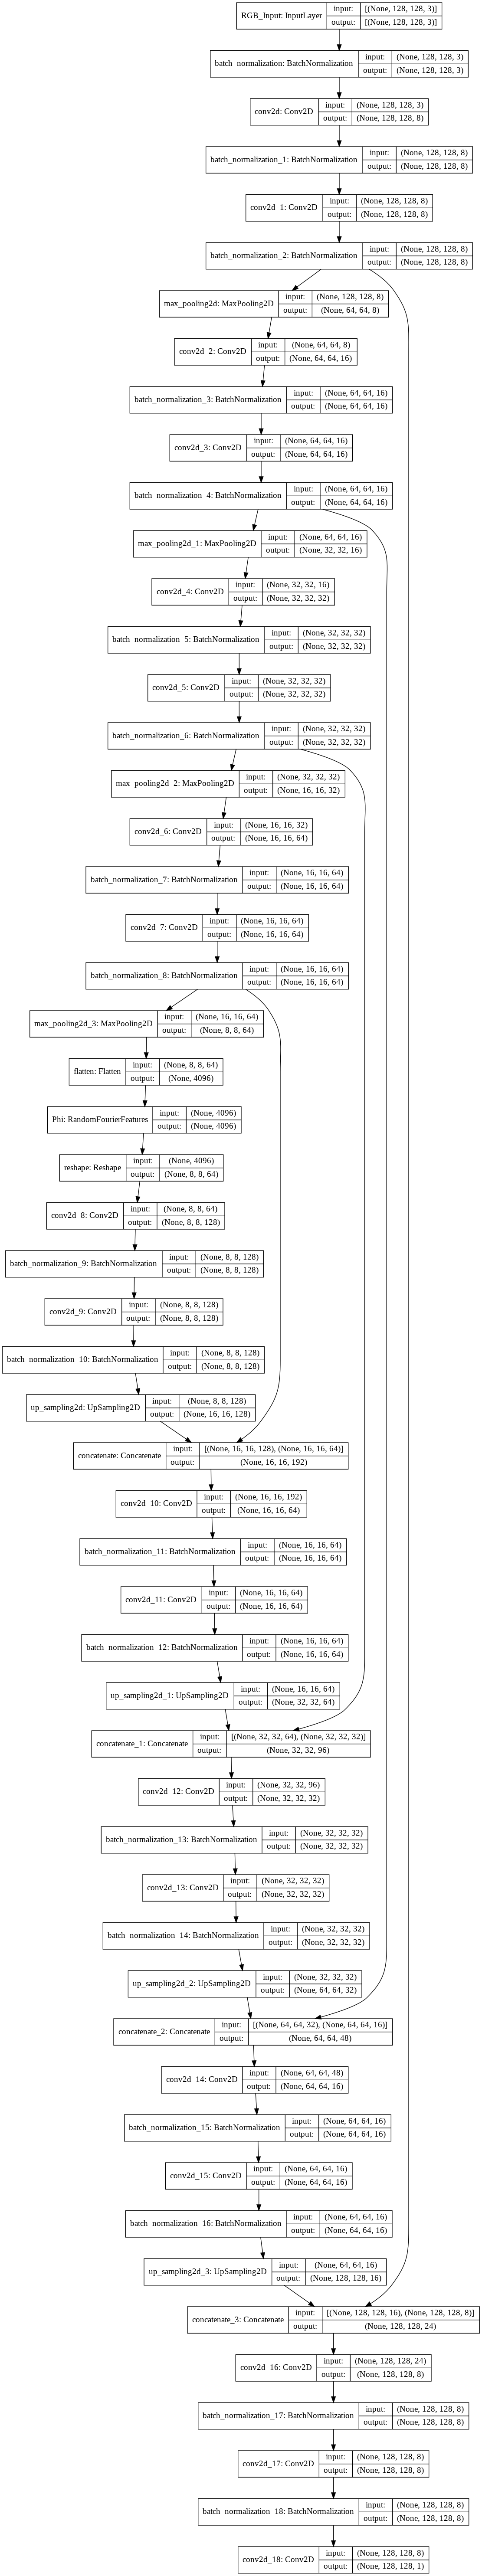

In [ ]:
tf.keras.utils.plot_model(model_Unet_RFF,show_layer_names=True,show_shapes=True)

# Mostrando un ejemplo de la Base de Datos

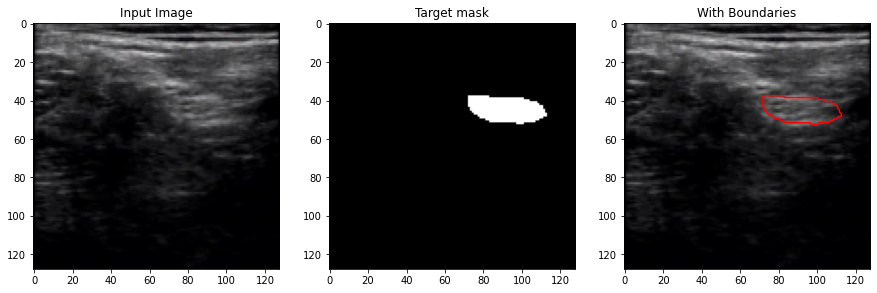

In [ ]:
path = './ImagenesNervios_/ciatico_5.png'
path_m = path[:-4] + '_mask.png'#'./ImagenesNervios_/ciatico_1_mask.png'
img = cv2.imread(path)/255  # normalizar imagen
img = cv2.resize(img,(128,128))
mask = cv2.imread(path_m)  # normalizar imagen
mask = cv2.resize(mask,(128,128))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Input Image')
plt.subplot(1,3,2)
plt.imshow(mask*255)
plt.title('Target mask')
plt.subplot(1,3,3)
plt.imshow(img)
edges = segmentation.clear_border(mask[:,:,0])  # countour
plt.contour(edges,[0.5],colors=['red'])
plt.title('With Boundaries')
plt.show()

In [ ]:
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

scorecam = Scorecam(model_Unet)
# score = tf.reduce
# cam = scorecam()

Tensorflow recognized 1 GPUs


In [ ]:
template_img = './ImagenesNervios_/ciatico_{}.png'
template_mask = './ImagenesNervios_/ciatico_{}_mask.png'
imgs = []
masks = []
for id in [1,2,3,4,5,6,7,8,9,10]:
  path = template_img.format(id)
  path_m = template_mask.format(id)
  img = cv2.imread(path)/255  # normalizar imagen
  img = cv2.resize(img,(128,128))
  mask = cv2.imread(path_m)  # normalizar imagen
  mask = cv2.resize(mask,(128,128))
  imgs.append(img)
  masks.append(mask)
imgs = np.array(imgs)
masks = np.array(masks)
masks = masks.astype(np.float32)
sgc =SegGradCam(masks[...,0][...,tf.newaxis])

cams = sgc.SegGradCam(model_Unet_RFF,img,cla=0,layer='conv2d_9')

In [ ]:
np.unique(masks)

array([0., 1.], dtype=float32)

(1, 128, 128)


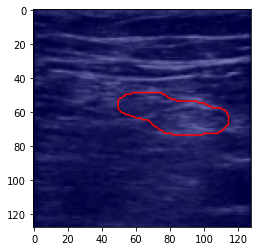

In [ ]:
sgc = SegGradCam(masks[0][np.newaxis,...])
cam = sgc.SegGradCam(model_Unet,img[np.newaxis,...],1,-4)

print(cam.shape)


from matplotlib import cm
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=.5)
edges = segmentation.clear_border(mask[:,:,0])
plt.contour(edges,[0.5],colors = ['red'])
plt.show()

In [ ]:
cam

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
128*128*128

2097152

# Cargar Lista de imagenes y mascaras.

In [ ]:
df_test_images = pd.DataFrame(load('./results.joblib')['test'])
filesname = df_test_images['filepath'].to_list()
masks_files = df_test_images['mask'].to_list()
test_t = df_test_images['nerve_name'].to_list()

# SEG-GRAD-CAM Promedio

## figure unet and Unet-RFF 

  0%|          | 0/1 [00:00<?, ?it/s]

conv2d_9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:207: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


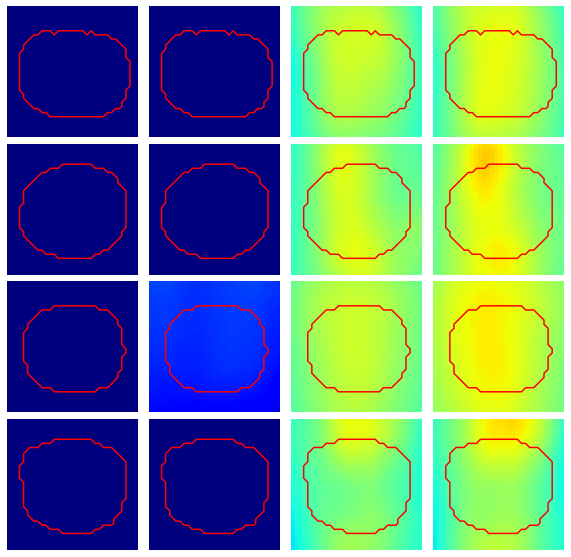

100%|██████████| 1/1 [00:21<00:00, 21.41s/it]


In [ ]:


for prop_to_layer in tqdm(['conv2d_{}'.format(i) for i in [9]]):
  print(prop_to_layer)
  BG_ori = []
  Ne_ori = []
  BG_rff = []
  Ne_rff = []
  edges = []
  for nerve in ['ciatico','mediano','cubital','femoral']:
    boolean = [x == nerve for x in test_t]
    filepath_n = [x for x,b in zip(filesname,boolean) if b]
    filepath_mask_n = [x for x,b in zip(masks_files,boolean) if b]
    GAP_0_ori,GAP_1_ori,edge =AverageSegGradCam(model_Unet,
                                                  filepath_n,
                                                  filepath_mask_n,
                                                  prop_to_layer=prop_to_layer,
                                                  plot = False)
    GAP_0_rff,GAP_1_rff,_ =AverageSegGradCam(model_Unet_RFF,
                                              filepath_n,
                                              filepath_mask_n,
                                              prop_to_layer=prop_to_layer,
                                              plot = False)
    GAP_0_ori[np.isnan(GAP_0_ori)]=0
    GAP_1_ori[np.isnan(GAP_1_ori)]=0
    GAP_0_rff[np.isnan(GAP_0_rff)]=0
    GAP_1_rff[np.isnan(GAP_1_rff)]=0

    BG_ori.append(GAP_0_ori) 
    Ne_ori.append(GAP_1_ori) 
    BG_rff.append(GAP_0_rff) 
    Ne_rff.append(GAP_1_rff) 
    edges.append(edge)

  vmax = np.hstack([BG_ori,BG_rff,Ne_ori,Ne_rff]).max()
  vmin = np.hstack([BG_ori,BG_rff,Ne_ori,Ne_rff]).min()
  fig = plt.figure(figsize = (10,10))
  j=0
  for i in range(4):
    j+=1
    plt.subplot(4,4,j)

    heatmap = np.uint8(cm.jet(BG_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')
    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(BG_rff[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_rff[i])[..., :3] * 255)
    pcm = plt.imshow(heatmap,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

  # fig.colorbar(pcm,ax=fig.axes[:])
  plt.subplots_adjust(wspace=.05,hspace=0.05,right=.78,left=0)


  plt.savefig('Global_Avegare_Relevance_Unet_{}.pdf'.format(prop_to_layer),dpi=300,pad_inches = 0)
  plt.show()

# For FCN

In [ ]:
# FILEID = "1KB0PcNhCDwbkYlI1GcOjHxICDT_B_uDu"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN.h5 && rm -rf /tmp/cookies.txt

# FILEID = "13yXIzHqOL6b2FpGJ-FFoYqigfZL7qQAX"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN-RFF-16.h5 && rm -rf /tmp/cookies.txt

# FILEID = "1V3P5NGy5ZsIrrcUAs0Pnj6vIXI8EwOda"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN-RFF-16-clipnorm.h5 && rm -rf /tmp/cookies.txt

# FILEID = "1-C5o4MFmxiAxayOvNCBYf6NB2F4G1CKM"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN-clipnorm.h5 && rm -rf /tmp/cookies.txt

# FILEID = "1-CqKSMuZbOLhIk2JeawC1iYeMjcJVCtK"
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN-RFF-16-clipnorm_2.h5 && rm -rf /tmp/cookies.txt

FILEID = "11Z5afS7Uv5NA57HwvuC-kK-fu1oEATBp"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN_v2.h5 && rm -rf /tmp/cookies.txt

FILEID = "11auDvFOwPuqBGNbYtLt4wjD191XCtAgb"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FCN-RFF-128_v2.h5 && rm -rf /tmp/cookies.txt

--2021-09-21 15:07:35--  https://docs.google.com/uc?export=download&confirm=&id=11Z5afS7Uv5NA57HwvuC-kK-fu1oEATBp
Resolving docs.google.com (docs.google.com)... 172.217.1.206, 2607:f8b0:4004:801::200e
Connecting to docs.google.com (docs.google.com)|172.217.1.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-18-docs.googleusercontent.com/docs/securesc/td2vjldcksacjd20m31tpni642210553/6djkrknjpachqv0nkd6968kd2tkfprbh/1632236850000/05137136237839183901/13763020190588029833Z/11Z5afS7Uv5NA57HwvuC-kK-fu1oEATBp?e=download [following]
--2021-09-21 15:07:36--  https://doc-0g-18-docs.googleusercontent.com/docs/securesc/td2vjldcksacjd20m31tpni642210553/6djkrknjpachqv0nkd6968kd2tkfprbh/1632236850000/05137136237839183901/13763020190588029833Z/11Z5afS7Uv5NA57HwvuC-kK-fu1oEATBp?e=download
Resolving doc-0g-18-docs.googleusercontent.com (doc-0g-18-docs.googleusercontent.com)... 172.217.0.33, 2607:f8b0:4004:800::2001
Connecting to doc-0g-18-doc

In [ ]:
df_test_images = pd.DataFrame(load('./results.joblib')['test'])
filesname = df_test_images['filepath'].to_list()
masks_files = df_test_images['mask'].to_list()
test_t = df_test_images['nerve_name'].to_list()

## Load models

In [ ]:
model_FCN_ori = tf.keras.models.load_model('./FCN_v2.h5',
                                           custom_objects={'dice_coef_loss':dice_coef_loss,
                                                           'iou':iou,
                                                           'dice_coef':dice_coef,
                                                           'sensitivity':sensitivity,
                                                           'specificity':specificity,
                                                           'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures
                                                           },
                                           compile=False)
model_FCN = tf.keras.Model(model_FCN_ori.inputs,[model_FCN_ori.get_layer('output').output]) #Modelo hasta la última capa convolucional
model_FCN.layers[-1].activation = None


model_FCN_RFF_ori = tf.keras.models.load_model('./FCN-RFF-128_v2.h5',custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                      'iou':iou,
                                                                      'dice_coef':dice_coef,
                                                                      'sensitivity':sensitivity,
                                                                      'specificity':specificity,
                                                                      'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures},
                                   compile=False)
model_FCN_RFF = tf.keras.Model(model_FCN_RFF_ori.inputs,[model_FCN_RFF_ori.get_layer('output').output]) #Modelo hasta la última capa convolucional
model_FCN_RFF.layers[-1].activation = None

In [ ]:
model_FCN.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 128, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         batch_normalization[0][0]        
___________________________________________________________________________________________

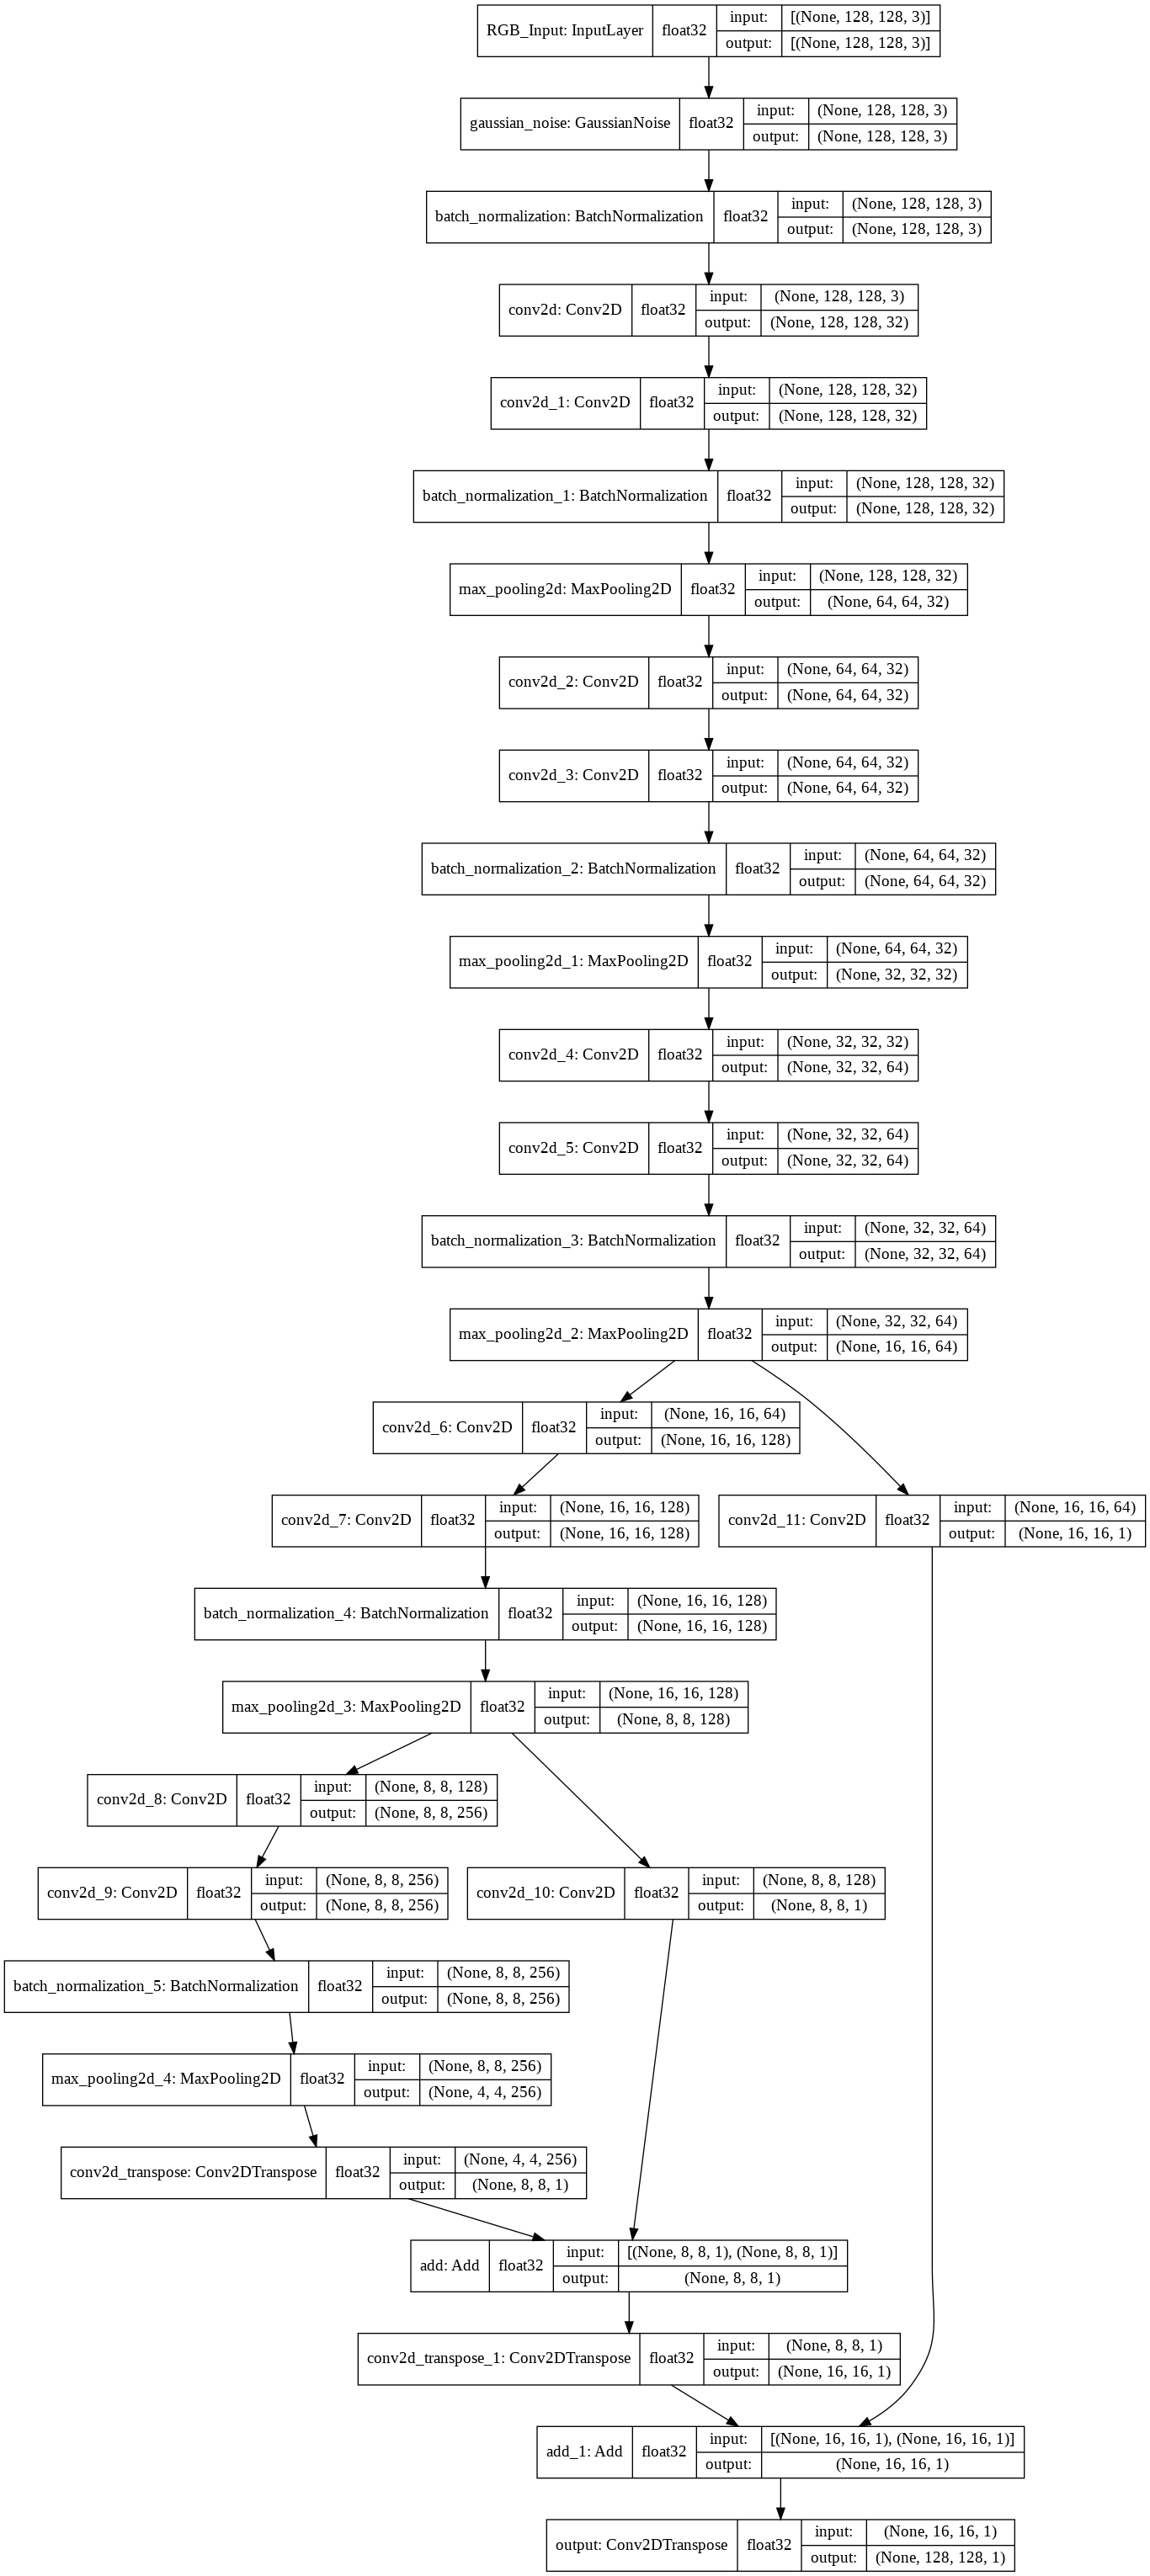

In [ ]:
tf.keras.utils.plot_model(model_FCN_ori,show_layer_names=True,show_shapes=True,expand_nested=True,show_dtype=True)

## figure FCN and FCN-RFF



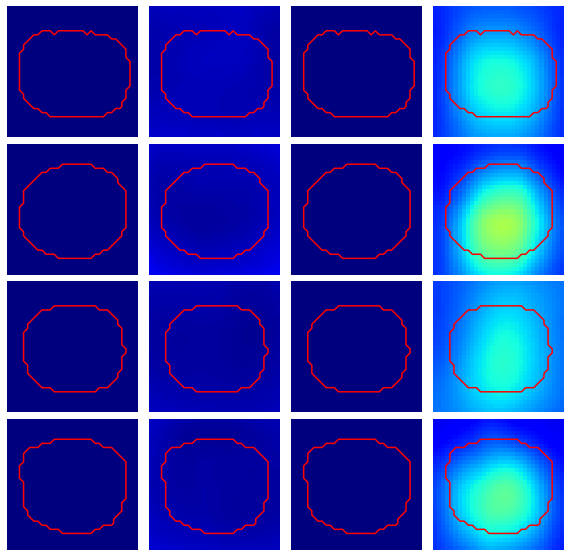

In [ ]:
prop_to_layer = 'add'
prop_from_layer = 'output'
BG_ori = []
Ne_ori = []
BG_rff = []
Ne_rff = []
edges = []
for nerve in ['ciatico','mediano','cubital','femoral']:
  boolean = [x == nerve for x in test_t]
  filepath_n = [x for x,b in zip(filesname,boolean) if b]
  filepath_mask_n = [x for x,b in zip(masks_files,boolean) if b]
  GAP_0_ori,GAP_1_ori,edge =AverageSegGradCam(model_FCN,
                                                filepath_n,
                                                filepath_mask_n,
                                                prop_to_layer=prop_to_layer,
                                                prop_from_layer=prop_from_layer,
                                                plot = False)
  GAP_0_rff,GAP_1_rff,_ =AverageSegGradCam(model_FCN_RFF,
                                            filepath_n,
                                            filepath_mask_n,
                                            prop_to_layer=prop_to_layer,
                                            prop_from_layer=prop_from_layer,
                                            plot = False)
  BG_ori.append(GAP_0_ori) 
  Ne_ori.append(GAP_1_ori) 
  BG_rff.append(GAP_0_rff) 
  Ne_rff.append(GAP_1_rff) 
  edges.append(edge)


fig = plt.figure(figsize = (10,10))
j=0
for i in range(4):
    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(BG_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')
    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(BG_rff[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_rff[i])[..., :3] * 255)
    pcm = plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

# fig.colorbar(pcm,ax=fig.axes[:])
plt.subplots_adjust(wspace=.05,hspace=0.05,right=.78,left=0)


plt.savefig('Global_Avegare_Relevance_FCN_{}.pdf'.format(prop_to_layer),dpi=300,pad_inches = 0)
plt.show()

# ResUnets


In [ ]:
FILEID = "1BrB8XRXZSzx4IK6tApDW1IIujHVAi57j"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ResUnet.h5 && rm -rf /tmp/cookies.txt


FILEID = "1iTLiN2OmZwUWvjyB9DfCzQqNcD6USnyG"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ResUnet-RFF-8.h5 && rm -rf /tmp/cookies.txt


FILEID = "1-KZ3d_a45e99BjBZceKuw3xRBXYVq7sN"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ResUnet-clipnorm.h5 && rm -rf /tmp/cookies.txt


FILEID = "1-LK6Pv_9Ok61NktTjOmVaiv--G4aUWrB"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ResUnet-RFF-8_clipnorm.h5 && rm -rf /tmp/cookies.txt

--2021-09-21 15:08:04--  https://docs.google.com/uc?export=download&confirm=&id=1BrB8XRXZSzx4IK6tApDW1IIujHVAi57j
Resolving docs.google.com (docs.google.com)... 142.250.81.206, 2607:f8b0:4004:814::200e
Connecting to docs.google.com (docs.google.com)|142.250.81.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-bk-docs.googleusercontent.com/docs/securesc/t06n2j148m9g6nb5cphb48ifg8d1gn79/4953acnrdcr40uddug2joh34omcjpfub/1632236850000/05137136237839183901/06909168122015350335Z/1BrB8XRXZSzx4IK6tApDW1IIujHVAi57j?e=download [following]
--2021-09-21 15:08:04--  https://doc-0k-bk-docs.googleusercontent.com/docs/securesc/t06n2j148m9g6nb5cphb48ifg8d1gn79/4953acnrdcr40uddug2joh34omcjpfub/1632236850000/05137136237839183901/06909168122015350335Z/1BrB8XRXZSzx4IK6tApDW1IIujHVAi57j?e=download
Resolving doc-0k-bk-docs.googleusercontent.com (doc-0k-bk-docs.googleusercontent.com)... 172.217.0.33, 2607:f8b0:4004:800::2001
Connecting to doc-0k-bk-d

In [ ]:
model_ResUnet_RFF_ori = tf.keras.models.load_model('./ResUnet-RFF-8.h5',custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                      'iou':iou,
                                                                      'dice_coef':dice_coef,
                                                                      'sensitivity':sensitivity,
                                                                      'specificity':specificity,
                                                                      'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures},
                                   compile=False)
model_ResUnet_RFF = tf.keras.Model(model_ResUnet_RFF_ori.inputs,[model_ResUnet_RFF_ori.get_layer('conv2d_54').output]) #Modelo hasta la última capa convolucional


model_ResUnet_ori = tf.keras.models.load_model('./ResUnet.h5',custom_objects={'dice_coef_loss':dice_coef_loss,
                                                                      'iou':iou,
                                                                      'dice_coef':dice_coef,
                                                                      'sensitivity':sensitivity,
                                                                      'specificity':specificity,
                                                                      'RandomFourierFeatures':tf.keras.layers.experimental.RandomFourierFeatures},
                                   compile=False)
model_ResUnet = tf.keras.Model(model_ResUnet_ori.inputs,[model_ResUnet_ori.get_layer('conv2d_54').output]) #Modelo hasta la última capa convolucional

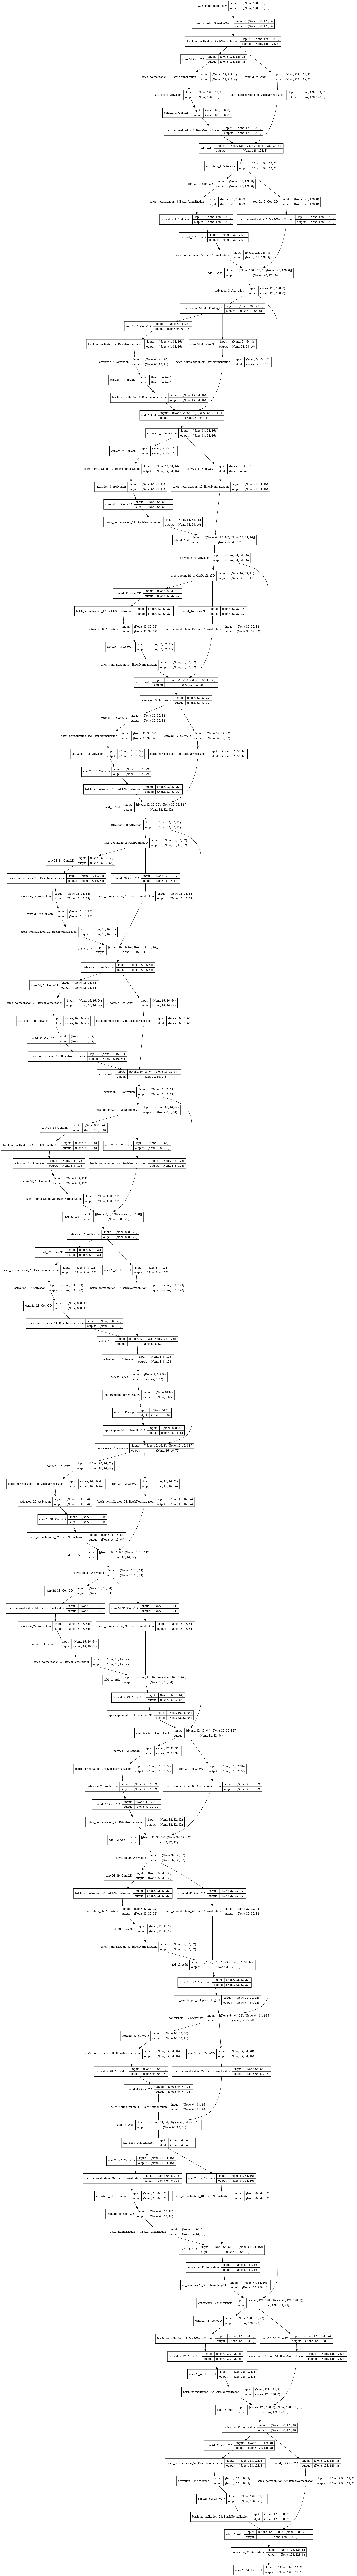

In [ ]:
tf.keras.utils.plot_model(model_ResUnet_RFF,show_layer_names=True,show_shapes=True)

## Figure ResUnet and ResUnet-RFF

In [ ]:
prop_to_layer = 'add_10'
prop_from_layer = 'conv2d_54'
BG_ori = []
Ne_ori = []
BG_rff = []
Ne_rff = []
edges = []
for nerve in ['ciatico','mediano','cubital','femoral']:
  boolean = [x == nerve for x in test_t]
  filepath_n = [x for x,b in zip(filesname,boolean) if b]
  filepath_mask_n = [x for x,b in zip(masks_files,boolean) if b]
  GAP_0_ori,GAP_1_ori,edge =AverageSegGradCam(model_ResUnet,
                                                filepath_n,
                                                filepath_mask_n,
                                                prop_to_layer=prop_to_layer,
                                                prop_from_layer=prop_from_layer,
                                                plot = False)
  GAP_0_rff,GAP_1_rff,_ =AverageSegGradCam(model_ResUnet_RFF,
                                            filepath_n,
                                            filepath_mask_n,
                                            prop_to_layer=prop_to_layer,
                                            prop_from_layer=prop_from_layer,
                                            plot = False)
  BG_ori.append(GAP_0_ori) 
  Ne_ori.append(GAP_1_ori) 
  BG_rff.append(GAP_0_rff) 
  Ne_rff.append(GAP_1_rff) 
  edges.append(edge)

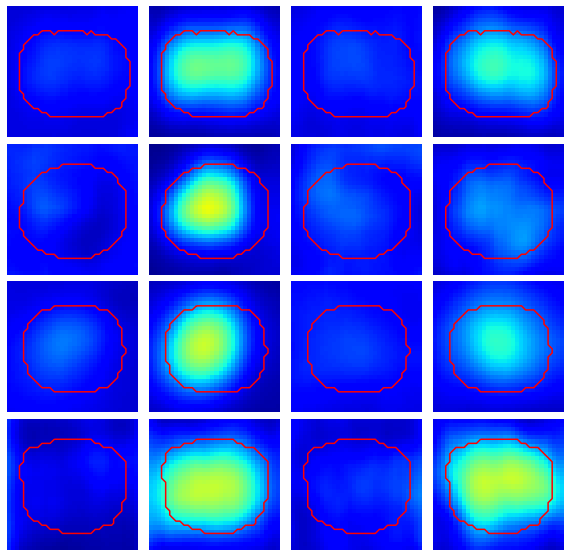

In [ ]:
vmax = np.hstack([BG_ori,BG_rff,Ne_ori,Ne_rff]).max()
vmin = np.hstack([BG_ori,BG_rff,Ne_ori,Ne_rff]).min()
fig = plt.figure(figsize = (10,10))
j=0
for i in range(4):
    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(BG_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')
    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_ori[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(BG_rff[i])[..., :3] * 255)
    plt.imshow(heatmap)#,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

    j+=1
    plt.subplot(4,4,j)
    heatmap = np.uint8(cm.jet(Ne_rff[i])[..., :3] * 255)
    pcm = plt.imshow(heatmap,vmin=vmin,vmax=vmax)
    plt.contour(edges[i],[0.5],colors=['red'])
    plt.axis('off')

  # fig.colorbar(pcm,ax=fig.axes[:])
plt.subplots_adjust(wspace=.05,hspace=0.05,right=.78,left=0)


plt.savefig('Global_Avegare_Relevance_ResUnet_{}.pdf'.format(prop_to_layer),dpi=300,pad_inches = 0)
plt.show()

# SegGradCam Maximum representation nerve

In [ ]:
def extract_cams(model, filesname,masks_files,test_t,prop_to_layer=-1):
  mdict = {}
  for nerve in tqdm(['ciatico','mediano','cubital','femoral']):
    boolean = [x == nerve for x in test_t]
    filepath_n = [x for x,b in zip(filesname,boolean) if b]
    filepath_mask_n = [x for x,b in zip(masks_files,boolean) if b]

    imgs = []
    masks = []
    indices  = []
    cams1 = []
    cams0 = []
    for path,path_m in zip(filepath_n,filepath_mask_n):
      img = cv2.imread(path)/255  # normalizar imagen
      img = cv2.resize(img,(128,128))
      mask = cv2.imread(path_m)  # normalizar imagen
      mask = cv2.resize(mask,(128,128))

      imgs.append(img)
      masks.append(mask)
    imgs = np.array(imgs)
    masks = np.array(masks)
    masks = masks.astype(np.float32)[...,0][...,np.newaxis]
    sgc = SegGradCam(masks)
    cams1 = sgc.SegGradCam(model,imgs,cla=1,layer=prop_to_layer)
    cams0 = sgc.SegGradCam(model,imgs,cla=0,layer=prop_to_layer)

    
    for mask,cam1,cam0 in zip(masks,cams1,cams0):
      ind = np.where(mask[...,0]==1) 
      indc = np.mean(cam1[ind]) - np.mean(cam0[ind])
      indices.append(indc)
      # cams1.append(cam1)
      # cams0.append(cam0)
      
    imgs = [img for img in imgs]
    masks = [mask for mask in masks]
    cams1 = [cam for cam in cams1]
    cams0 = [cam for cam in cams0]

    mdict[nerve] = {'imgs':imgs,
                    'masks':masks,
                    'cam1':cams1,
                    'cam0':cams0,
                    'indice':indices}
  return mdict

In [ ]:
Unet_dict = extract_cams(model_Unet,filesname,masks_files,test_t,prop_to_layer='conv2d_9')
Unet_RFF_dict = extract_cams(model_Unet_RFF,filesname,masks_files,test_t,prop_to_layer='conv2d_9')

100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


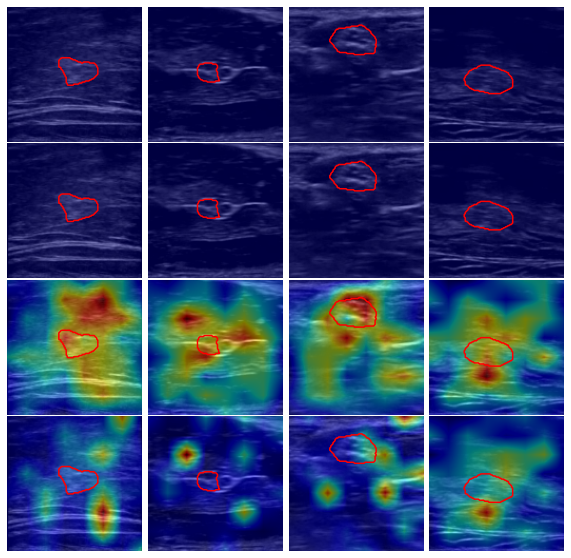

In [ ]:
# ind = ind = np.argmax(Unet_RFF_dict[nerve]['indice'])
dicts = [Unet_dict,Unet_RFF_dict]
plt.figure(figsize=(10,10))
j = 1
for dic in dicts:
  for cla in [1,0]:
    for nerve in ['ciatico','cubital','mediano','femoral']:
      name_cam = 'cam0' if cla==0 else 'cam1'
      ind = np.argmax(Unet_RFF_dict[nerve]['indice'])
      img = dic[nerve]['imgs'][ind]
      mask = dic[nerve]['masks'][ind]
      cam = dic[nerve][name_cam][ind]
      cam[np.isnan(cam)] = 0
      plt.subplot(4,4,j)
      heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
      plt.imshow(img)
      plt.imshow(heatmap, cmap='jet', alpha=.5)
      edges = segmentation.clear_border(mask[:,:,0])
      plt.contour(edges,[0.5],colors = ['red'])
      plt.axis('off')

      j += 1

plt.subplots_adjust(wspace=.01,hspace=0.01,right=.78,left=0)
plt.savefig('./Example_Unet.pdf')
plt.show()
  

100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


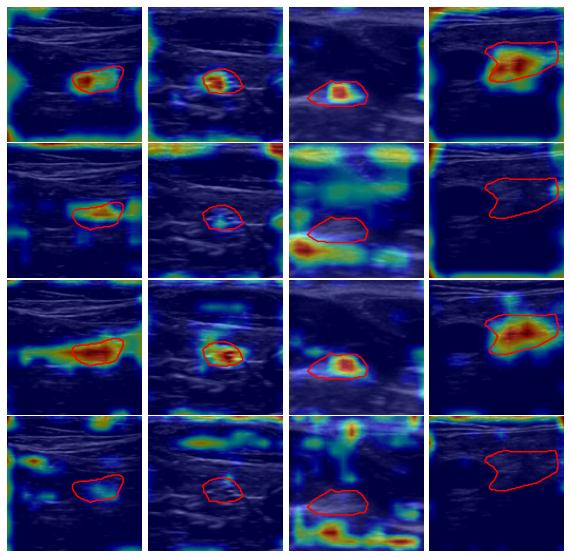

In [ ]:
ResUnet_dict = extract_cams(model_ResUnet,filesname,masks_files,test_t,prop_to_layer='add_10')
ResUnet_RFF_dict = extract_cams(model_ResUnet_RFF,filesname,masks_files,test_t,prop_to_layer='add_10')

dicts = [ResUnet_dict,
         ResUnet_RFF_dict]
plt.figure(figsize=(10,10))
j = 1
for dic in dicts:
  for cla in [1,0]:
    for nerve in ['ciatico','cubital','mediano','femoral']:
      name_cam = 'cam0' if cla==0 else 'cam1'
      ind = np.argsort(ResUnet_RFF_dict[nerve]['indice'])[-2]
      img = dic[nerve]['imgs'][ind]
      mask = dic[nerve]['masks'][ind]
      cam = dic[nerve][name_cam][ind]
      cam[np.isnan(cam)] = 0
      plt.subplot(4,4,j)
      heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
      plt.imshow(img)
      plt.imshow(heatmap, cmap='jet', alpha=.5)
      edges = segmentation.clear_border(mask[:,:,0])
      plt.contour(edges,[0.5],colors = ['red'])
      plt.axis('off')

      j += 1

plt.subplots_adjust(wspace=.01,hspace=0.01,right=.78,left=0)
plt.savefig('./Example_ResUnet.pdf')
plt.show()
  

In [ ]:
layer_p = 'add'
FCN_dict = extract_cams(model_FCN,filesname,masks_files,test_t,prop_to_layer=layer_p)
FCN_RFF_dict = extract_cams(model_FCN_RFF,filesname,masks_files,test_t,prop_to_layer=layer_p)

dicts = [FCN_dict,
         FCN_RFF_dict]
plt.figure(figsize=(10,10))
j = 1
for dic in dicts:
  for cla in [1,0]:
    for nerve in ['ciatico','cubital','mediano','femoral']:
      name_cam = 'cam0' if cla==0 else 'cam1'
      ind = np.argmax(FCN_RFF_dict[nerve]['indice'])
      img = dic[nerve]['imgs'][ind]
      mask = dic[nerve]['masks'][ind]
      cam = dic[nerve][name_cam][ind]
      cam[np.isnan(cam)] = 0
      plt.subplot(4,4,j)
      heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
      plt.imshow(img)
      plt.imshow(heatmap, cmap='jet', alpha=.5)
      edges = segmentation.clear_border(mask[:,:,0])
      plt.contour(edges,[0.5],colors = ['red'])
      plt.axis('off')

      j += 1

plt.subplots_adjust(wspace=.01,hspace=0.01,right=.78,left=0)
plt.savefig('./Example_FCN.pdf')
plt.show()
  

In [ ]:
!cp ./*.pdf ./drive/MyDrive/img_pdfs/